<a href="https://colab.research.google.com/github/sjoon0305/Simulation/blob/main/4_Lorenz_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem setup
We will solve Lorenz System Inverse problem:

$$\frac{dx}{dt} = \sigma(y-x),\quad \frac{dy}{dt} = x(\rho-z)-y, \quad \frac{dz}{dt} = xy-\beta z, \qquad t \in [0, 3],$$

with initial condition

$$x(0)=-8,\quad y(0)=7,\quad z(0) =27$$


The exact parameters are
$$ \sigma=10,\quad \rho=7,\quad \beta=\frac{8}{3}$$

In [1]:
import torch
import torch.nn as nn
import numpy as np
from torch.autograd import Variable
import matplotlib.pyplot as plt

In [2]:
# 파일 다운로드, 파라미터 추정을 위해 학습 전에 미리 얻는 데이터
!wget -O /content/Lorenz.npz https://raw.githubusercontent.com/lululxvi/deepxde/master/examples/dataset/Lorenz.npz

--2024-11-20 09:14:29--  https://raw.githubusercontent.com/lululxvi/deepxde/master/examples/dataset/Lorenz.npz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1250 (1.2K) [application/octet-stream]
Saving to: ‘/content/Lorenz.npz’

/content/Lorenz.npz 100%[===================>]   1.22K  --.-KB/s    in 0s      

2024-11-20 09:14:29 (75.0 MB/s) - ‘/content/Lorenz.npz’ saved [1250/1250]



In [3]:
# 다운받은 데이터 읽어오기
def gen_traindata():
    data = np.load("../content/Lorenz.npz")
    return data["t"], data["y"]

observe_t, ob_u = gen_traindata()
observe_x, observe_y, observe_z = ob_u[:, 0:1], ob_u[:, 1:2], ob_u[:, 2:3]

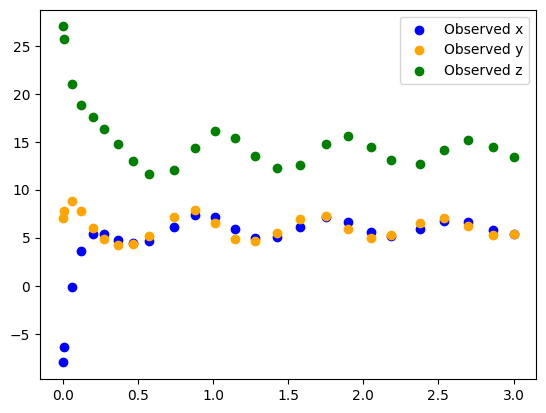

In [4]:
# 데이터 시각화
plt.scatter(observe_t, observe_x, label='Observed x', color='blue')
plt.scatter(observe_t, observe_y, label='Observed y', color='orange')
plt.scatter(observe_t, observe_z, label='Observed z', color='green')
plt.legend()

In [5]:
# 모델 구성
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden_layer1 = nn.Linear(1,50)
        self.hidden_layer2 = nn.Linear(50,50)
        self.output_layer = nn.Linear(50,3)

    def forward(self, t):
        layer1_out = torch.tanh(self.hidden_layer1(t))
        layer2_out = torch.tanh(self.hidden_layer2(layer1_out))
        output = self.output_layer(layer2_out)
        return output[:, 0:1], output[:, 1:2], output[:, 2:]

In [6]:
# sigma, rho, beta
C1 = torch.tensor(1.0, requires_grad=True)
C2 = torch.tensor(1.0, requires_grad=True)
C3 = torch.tensor(1.0, requires_grad=True)
external_trainable_variables = [C1, C2, C3]

### (2) Model
net = Net()
mse_cost_function = torch.nn.MSELoss() # Mean squared error
optimizer = torch.optim.Adam([
    {'params': net.parameters()},
    {'params': external_trainable_variables} #  σ, ρ, β : 모두 1로 가정
    ], lr = 0.001)

In [7]:
def Inverse_Lorenz(net, t):
    x, y, z = net(t)
    dx_t = torch.autograd.grad(x.sum(), t, create_graph=True)[0]
    dy_t = torch.autograd.grad(y.sum(), t, create_graph=True)[0]
    dz_t = torch.autograd.grad(z.sum(), t, create_graph=True)[0]

    pde1 = dx_t - C1 * (y - x)
    pde2 = dy_t - x * (C2 - z) + y
    pde3 = dz_t - x * y + C3 * z

    return (pde1.pow(2).sum() + pde2.pow(2).sum() + pde3.pow(2).sum()) / t.shape[0]

def ic_loss(net, init_t, init_x, init_y, init_z):
  x_out, y_out, z_out = net(init_t)
  loss = (x_out-init_x).pow(2).sum()/init_t.shape[0]+(y_out-init_y).pow(2).sum()/init_t.shape[0]+(z_out-init_z).pow(2).sum()/init_t.shape[0]
  return loss

def data_loss(net, data_t, data_x, data_y, data_z):
  x_out, y_out, z_out = net(data_t)
  loss = (x_out-data_x).pow(2).sum()/data_t.shape[0]+(y_out-data_y).pow(2).sum()/data_t.shape[0]+(z_out-data_z).pow(2).sum()/data_t.shape[0]
  return loss

In [8]:
pt_observe_t = torch.from_numpy(observe_t).float().requires_grad_()
pt_observe_x = torch.from_numpy(observe_x).float().requires_grad_()
pt_observe_y = torch.from_numpy(observe_y).float().requires_grad_()
pt_observe_z = torch.from_numpy(observe_z).float().requires_grad_()

In [ ]:
### (3) Training / Fitting (optimizer:Adam)
iterations = 30000
# Training loss를 저장할 리스트 초기화
training_losses = []
C1_values = []
C2_values = []
C3_values = []

for epoch in range(iterations):

    # Loss based on IC
    pt_t_ic = torch.zeros((50, 1), requires_grad=True)
    Loss_ic = ic_loss(net,pt_t_ic,-8, 7, 27)

    # Loss based on PDE
    t_collocation = torch.empty((50, 1)).uniform_(0., 3.).requires_grad_()
    Loss_pde = Inverse_Lorenz(net, t_collocation)

    # Loss based on Data
    Loss_data = data_loss(net, pt_observe_t, pt_observe_x, pt_observe_y, pt_observe_z)

    # Combining the loss functions
    Total_Loss =  Loss_ic + Loss_pde + Loss_data

    optimizer.zero_grad() # to make the gradients zero
    Total_Loss.backward() # This is for computing gradients using backward propagation
    optimizer.step()

    C1_values.append(C1.item())
    C2_values.append(C2.item())
    C3_values.append(C3.item())

    training_losses.append(Total_Loss.item())

    if epoch == 1 or epoch % 1000 == 0:
        print(f'Epoch: {epoch}, Loss: {float(Total_Loss):.3}')

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(range(iterations), C1_values, label='σ predict')
plt.plot(range(iterations), C2_values, label='ρ predict')
plt.plot(range(iterations), C3_values, label='β predict')
plt.axhline(y=10, linestyle='--', label='σ :10')
plt.axhline(y=15, color='orange', linestyle='--', label='ρ :15')
plt.axhline(y=8/3, color='g', linestyle='--', label='β :8/3')
plt.xlabel('Iterations')
plt.ylabel('Values')
plt.title('C1, C2, C3 values over iterations')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(iterations), training_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
t = np.arange(0, 3, 0.001)
t = np.ravel(t).reshape(-1, 1)
pt_t = Variable(torch.from_numpy(t).float(), requires_grad=True)
pt_x,pt_y,pt_z = net(pt_t)
x = pt_x.data.cpu().numpy()
x = x.reshape(t.shape)

y = pt_y.data.cpu().numpy()
y = y.reshape(t.shape)

z = pt_z.data.cpu().numpy()
z = z.reshape(t.shape)

plt.plot(t,x, label='Predicted x')
plt.plot(t,y, label='Predicted y')
plt.plot(t,z, label='Predicted z')

plt.scatter(observe_t, ob_u[:, 0], label='Observed x', color='blue')
plt.scatter(observe_t, ob_u[:, 1], label='Observed y', color='orange')
plt.scatter(observe_t, ob_u[:, 2], label='Observed z', color='green')

plt.title('Predicted vs Observed')
plt.legend()
plt.show()